In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Ceará - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_CE.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Ceará - Desemprego,Ceará - Consumo de Cimento (t),Ceará - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - PIB - Preços de Mercado,Ceará - Produção de Cimento (t)
0,2003-1,8.274459,81.265,0.301376,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.684040,6.965352e+07,4.525724e+06,7.532751,6.293821e+07,107.673000
1,2003-2,8.268512,65.200,0.301393,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.684476,6.974354e+07,4.530359e+06,7.535808,6.297178e+07,107.237962
2,2003-3,8.262564,55.165,0.301309,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.684912,6.983356e+07,4.534994e+06,7.538865,6.300536e+07,108.742184
3,2003-4,8.256617,53.928,0.300917,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.685347,6.992358e+07,4.539629e+06,7.541921,6.303893e+07,109.391112
4,2003-5,8.250670,65.334,0.300417,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.685783,7.001361e+07,4.544265e+06,7.544978,6.307250e+07,111.602457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,186.918,0.535686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239.122997
236,2022-9,NaN,179.828,0.533990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239.220173
237,2022-10,NaN,174.940,0.530449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,237.879214
238,2022-11,NaN,182.597,0.526253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236.799325


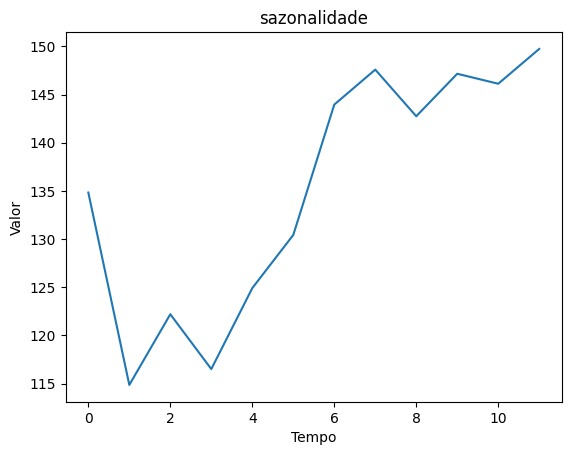

,sazonalidade
sazonalidade,
0,134.830286
1,114.853857
2,122.193393
3,116.499214
4,124.906357
5,130.428000
6,143.963071
7,147.594429
8,142.753000


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Ceará - Desemprego,Ceará - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - PIB - Preços de Mercado,Ceará - Produção de Cimento (t),sazonalidade,Ceará - Consumo de Cimento (t)
0,2003-1,8.274459,0.301376,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.684040,6.965352e+07,4.525724e+06,7.532751,6.293821e+07,107.673000,134.830286,81.265
1,2003-2,8.268512,0.301393,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.684476,6.974354e+07,4.530359e+06,7.535808,6.297178e+07,107.237962,114.853857,65.200
2,2003-3,8.262564,0.301309,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.684912,6.983356e+07,4.534994e+06,7.538865,6.300536e+07,108.742184,122.193393,55.165
3,2003-4,8.256617,0.300917,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.685347,6.992358e+07,4.539629e+06,7.541921,6.303893e+07,109.391112,116.499214,53.928
4,2003-5,8.250670,0.300417,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.685783,7.001361e+07,4.544265e+06,7.544978,6.307250e+07,111.602457,124.906357,65.334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,0.535686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239.122997,147.594429,186.918
236,2022-9,NaN,0.533990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239.220173,142.753000,179.828
237,2022-10,NaN,0.530449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,237.879214,147.165286,174.940
238,2022-11,NaN,0.526253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236.799325,146.128000,182.597


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      91.341
1      69.730
2      77.682
3      66.140
4      76.289
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Ceará - Consumo de Cimento (t), Length: 240, dtype: float64

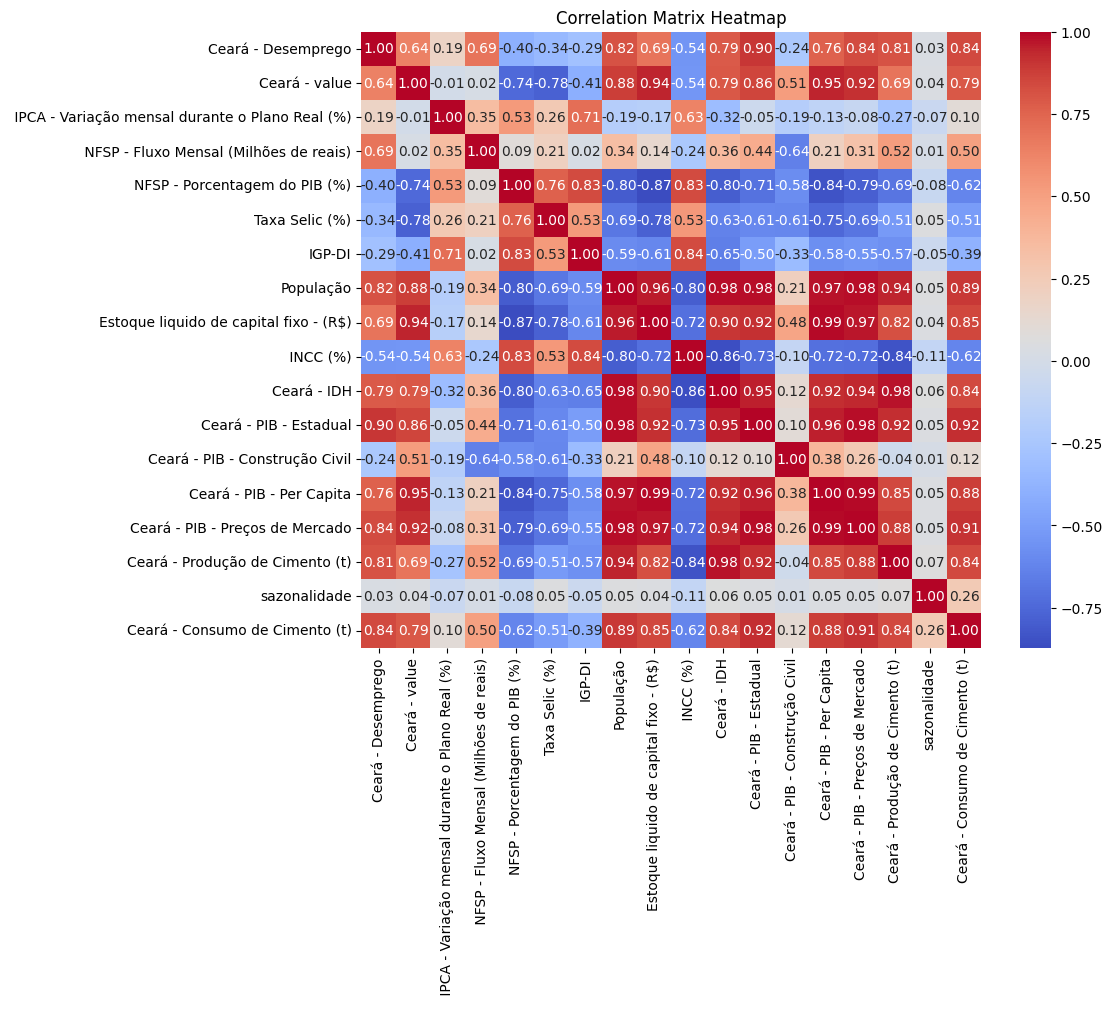

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Ceará - Desemprego,6.001289e+03
1,Ceará - value,3.648727e+04
2,IPCA - Variação mensal durante o Plano Real (%),1.811653e+03
3,NFSP - Fluxo Mensal (Milhões de reais),2.311244e+02
4,NFSP - Porcentagem do PIB (%),5.135085e+02
5,Taxa Selic (%),5.843431e+01
6,IGP-DI,4.320098e+02
7,População,4.255371e+06
8,Estoque liquido de capital fixo - (R$),1.540362e+07
9,INCC (%),9.636755e+02


In [39]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 1


,Ceará - Desemprego,Ceará - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Preços de Mercado,Ceará - Produção de Cimento (t),sazonalidade
0,8.274459,0.301376,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.684040,6.965352e+07,4.525724e+06,6.293821e+07,107.673000,134.830286
1,8.268512,0.301393,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.684476,6.974354e+07,4.530359e+06,6.297178e+07,107.237962,114.853857
2,8.262564,0.301309,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.684912,6.983356e+07,4.534994e+06,6.300536e+07,108.742184,122.193393
3,8.256617,0.300917,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.685347,6.992358e+07,4.539629e+06,6.303893e+07,109.391112,116.499214
4,8.250670,0.300417,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.685783,7.001361e+07,4.544265e+06,6.307250e+07,111.602457,124.906357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,10.636050,0.357620,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,0.729744,8.386519e+07,4.576520e+06,6.609798e+07,187.438155,147.594429
176,10.625073,0.359211,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,0.729742,8.384358e+07,4.576942e+06,6.608592e+07,187.356403,142.753000
177,10.614096,0.361147,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,0.729740,8.382198e+07,4.577364e+06,6.607386e+07,187.395781,147.165286
178,10.603119,0.363313,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,0.729739,8.380037e+07,4.577786e+06,6.606180e+07,187.375581,146.128000


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Ceará - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Preços de Mercado,Ceará - Produção de Cimento (t)
0,0.110899,1.000000,0.543630,1.000000,0.741706,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.005362
1,0.111104,0.909144,0.544990,0.965719,0.573104,0.936603,0.008302,0.011007,0.968765,0.009526,0.006268,0.014215,0.010056,0.000000
2,0.110066,0.853620,0.532585,0.927412,0.925680,0.906543,0.016605,0.022015,0.948151,0.019053,0.012535,0.028430,0.020111,0.018540
3,0.105225,0.828878,0.504220,0.885588,0.542253,0.858675,0.024907,0.033022,0.928398,0.028579,0.018803,0.042645,0.030167,0.026539
4,0.099059,0.796137,0.515509,0.838034,0.803992,0.824839,0.033209,0.044030,0.970256,0.038106,0.025071,0.056860,0.040222,0.053795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.805359,0.038179,0.496222,0.033352,0.034086,0.168620,0.986456,0.889786,0.020697,0.999718,0.989470,0.155781,0.946371,0.988517
176,0.824994,0.016717,0.473326,0.034217,0.187836,0.176428,0.989842,0.885419,0.019895,0.999678,0.987965,0.157075,0.942758,0.987509
177,0.848900,0.004270,0.425824,0.035996,0.269786,0.174368,0.993228,0.881053,0.020180,0.999637,0.986461,0.158368,0.939146,0.987995
178,0.875649,0.000000,0.448015,0.039184,0.360889,0.197726,0.996614,0.876686,0.007298,0.999597,0.984957,0.159662,0.935534,0.987746


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Ceará - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Preços de Mercado,Ceará - Produção de Cimento (t)
0,0.110899,1.000000,0.543630,1.000000,0.741706,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.005362
1,0.111104,0.909144,0.544990,0.965719,0.573104,0.936603,0.008302,0.011007,0.968765,0.009526,0.006268,0.014215,0.010056,0.000000
2,0.110066,0.853620,0.532585,0.927412,0.925680,0.906543,0.016605,0.022015,0.948151,0.019053,0.012535,0.028430,0.020111,0.018540
3,0.105225,0.828878,0.504220,0.885588,0.542253,0.858675,0.024907,0.033022,0.928398,0.028579,0.018803,0.042645,0.030167,0.026539
4,0.099059,0.796137,0.515509,0.838034,0.803992,0.824839,0.033209,0.044030,0.970256,0.038106,0.025071,0.056860,0.040222,0.053795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.603422,0.144755,0.772284,0.015040,0.428805,0.061396,0.945698,0.937006,0.094130,0.994109,0.995709,0.216071,0.973767,0.983926
164,0.618289,0.133956,0.741958,0.016631,0.394850,0.095565,0.949109,0.933675,0.087555,0.995287,0.996567,0.202202,0.973345,0.988586
165,0.635485,0.141095,0.686725,0.018850,0.402192,0.096417,0.952520,0.930344,0.083404,0.996465,0.997426,0.188333,0.972923,0.995051
166,0.648082,0.102393,0.792808,0.020846,0.428809,0.052056,0.955931,0.927013,0.075773,0.997643,0.998284,0.174464,0.972501,1.000000


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       91.341
1       69.730
2       77.682
3       66.140
4       76.289
        ...   
163    177.259
164    155.913
165    172.410
166    179.419
167    157.165
Name: Ceará - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 14)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Ceará - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Preços de Mercado,Ceará - Produção de Cimento (t)
132,0.998034,0.710818,0.600233,0.076793,0.228507,0.297841,0.834889,1.000000,0.368307,0.701898,0.912099,0.708921,1.000000,0.579764
133,0.995668,0.737933,0.683286,0.080065,0.227972,0.310249,0.838610,0.999030,0.356043,0.702829,0.915859,0.695822,0.998456,0.590034
134,0.993189,0.731922,0.691333,0.083086,0.297136,0.298259,0.842332,0.998060,0.365871,0.703760,0.919618,0.682724,0.996912,0.606009
135,0.988080,0.722500,0.683763,0.085709,0.190626,0.264133,0.846053,0.997090,0.374560,0.704691,0.923377,0.669626,0.995368,0.622323
136,0.981506,0.735417,0.750790,0.089485,0.174875,0.283400,0.849774,0.996121,0.347016,0.705622,0.927136,0.656528,0.993824,0.639054
137,0.968452,0.736663,0.748426,0.091963,0.212105,0.345980,0.853496,0.995151,0.340984,0.706553,0.930896,0.643430,0.992280,0.656025
138,0.947417,0.750484,0.765274,0.093682,0.239148,0.355524,0.857217,0.994181,0.333970,0.707484,0.934655,0.630332,0.990736,0.673354
139,0.924448,0.781650,0.799973,0.094876,0.292080,0.388252,0.860938,0.993211,0.316991,0.708415,0.938414,0.617234,0.989192,0.691037
140,0.901748,0.780630,0.803815,0.095765,0.237576,0.392252,0.864660,0.992241,0.324046,0.709346,0.942174,0.604136,0.987648,0.709145
141,0.885016,0.771685,0.692895,0.095412,0.297638,0.401389,0.868381,0.991271,0.324890,0.710277,0.945933,0.591038,0.986104,0.727666


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 14)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(144, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(72, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3110953523, 3378025677, 11526064, 743115139, 2834628878, 130514385, 31223545, 4282121734, 3733208578, 4084101289]


Step: 0 ___________________________________________
val_loss: 710.1595458984375
winner_seed: 3110953523


Step: 1 ___________________________________________
val_loss: 776.55322265625


Step: 2 ___________________________________________
val_loss: 783.4468994140625


Step: 3 ___________________________________________
val_loss: 804.7125854492188


Step: 4 ___________________________________________
val_loss: 1723.0357666015625


Step: 5 ___________________________________________
val_loss: 686.0888671875
winner_seed: 130514385


Step: 6 ___________________________________________
val_loss: 876.7318115234375


Step: 7 ___________________________________________
val_loss: 703.0094604492188


Step: 8 ___________________________________________
val_loss: 1137.63525390625


Step: 9 ___________________________________________
val_loss: 21825.572265625


final_seed: 130514385


In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 117ms/step - loss: 19084.4062 - val_loss: 675.9606
Epoch 2/10000
4/4 [==============================] - 0s 10ms/step - loss: 1512.9958 - val_loss: 777.9722
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 1493.3440 - val_loss: 933.6738
Epoch 4/10000
4/4 [==============================] - 0s 10ms/step - loss: 1493.7831 - val_loss: 807.8544
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 1552.4219 - val_loss: 1122.2698
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 1502.6143 - val_loss: 647.0458
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 1525.2103 - val_loss: 771.7344
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 1496.1259 - val_loss: 1047.1351
Epoch 9/10000
4/4 [==============================] - 0s 9ms/step - loss: 1646.8229 - val_loss: 668.0576
Epoch 10/10000
4/4 [==============================] - 0s

Epoch 79/10000
4/4 [==============================] - 0s 9ms/step - loss: 1492.5811 - val_loss: 683.4200
Epoch 80/10000
4/4 [==============================] - 0s 9ms/step - loss: 1577.4232 - val_loss: 786.5394
Epoch 81/10000
4/4 [==============================] - 0s 10ms/step - loss: 1482.1504 - val_loss: 996.6360
Epoch 82/10000
4/4 [==============================] - 0s 9ms/step - loss: 1522.9192 - val_loss: 905.0526
Epoch 83/10000
4/4 [==============================] - 0s 10ms/step - loss: 1503.3422 - val_loss: 1016.2281
Epoch 84/10000
4/4 [==============================] - 0s 9ms/step - loss: 1119.9691 - val_loss: 1405.7064
Epoch 85/10000
4/4 [==============================] - 0s 10ms/step - loss: 1147.8751 - val_loss: 2191.8105
Epoch 86/10000
4/4 [==============================] - 0s 9ms/step - loss: 1706.4033 - val_loss: 812.5223
Epoch 87/10000
4/4 [==============================] - 0s 9ms/step - loss: 1507.5393 - val_loss: 788.2764
Epoch 88/10000
4/4 [=============================

4/4 [==============================] - 0s 8ms/step - loss: 808.3425 - val_loss: 1415.0785
Epoch 157/10000
4/4 [==============================] - 0s 9ms/step - loss: 985.4522 - val_loss: 3306.1794
Epoch 158/10000
4/4 [==============================] - 0s 9ms/step - loss: 827.5560 - val_loss: 2712.6077
Epoch 159/10000
4/4 [==============================] - 0s 9ms/step - loss: 614.7305 - val_loss: 3053.9155
Epoch 160/10000
4/4 [==============================] - 0s 9ms/step - loss: 557.1703 - val_loss: 2808.1047
Epoch 161/10000
4/4 [==============================] - 0s 9ms/step - loss: 575.6209 - val_loss: 3319.3240
Epoch 162/10000
4/4 [==============================] - 0s 9ms/step - loss: 578.7597 - val_loss: 3438.1094
Epoch 163/10000
4/4 [==============================] - 0s 9ms/step - loss: 554.6097 - val_loss: 2757.4441
Epoch 164/10000
4/4 [==============================] - 0s 9ms/step - loss: 798.2369 - val_loss: 726.7067
Epoch 165/10000
4/4 [==============================] - 0s 9ms/s

4/4 [==============================] - 0s 9ms/step - loss: 545.5370 - val_loss: 2094.8513
Epoch 234/10000
4/4 [==============================] - 0s 9ms/step - loss: 835.4786 - val_loss: 2411.9895
Epoch 235/10000
4/4 [==============================] - 0s 9ms/step - loss: 547.0626 - val_loss: 2746.3337
Epoch 236/10000
4/4 [==============================] - 0s 9ms/step - loss: 482.3221 - val_loss: 1068.3821
Epoch 237/10000
4/4 [==============================] - 0s 9ms/step - loss: 710.2330 - val_loss: 1768.5100
Epoch 238/10000
4/4 [==============================] - 0s 10ms/step - loss: 598.9847 - val_loss: 3140.1011
Epoch 239/10000
4/4 [==============================] - 0s 9ms/step - loss: 577.4974 - val_loss: 3011.4792
Epoch 240/10000
4/4 [==============================] - 0s 9ms/step - loss: 520.2744 - val_loss: 2968.4075
Epoch 241/10000
4/4 [==============================] - 0s 10ms/step - loss: 795.9079 - val_loss: 739.8560
Epoch 242/10000
4/4 [==============================] - 0s 9ms

4/4 [==============================] - 0s 10ms/step - loss: 445.2781 - val_loss: 2202.6951
Epoch 311/10000
4/4 [==============================] - 0s 9ms/step - loss: 582.0673 - val_loss: 1685.0123
Epoch 312/10000
4/4 [==============================] - 0s 9ms/step - loss: 474.2006 - val_loss: 1263.9308
Epoch 313/10000
4/4 [==============================] - 0s 9ms/step - loss: 516.1208 - val_loss: 1360.8093
Epoch 314/10000
4/4 [==============================] - 0s 9ms/step - loss: 444.7995 - val_loss: 3913.5112
Epoch 315/10000
4/4 [==============================] - 0s 9ms/step - loss: 724.9177 - val_loss: 2131.6287
Epoch 316/10000
4/4 [==============================] - 0s 9ms/step - loss: 413.2276 - val_loss: 985.0787
Epoch 317/10000
4/4 [==============================] - 0s 9ms/step - loss: 672.8685 - val_loss: 1710.2166
Epoch 318/10000
4/4 [==============================] - 0s 9ms/step - loss: 463.0995 - val_loss: 3018.3315
Epoch 319/10000
4/4 [==============================] - 0s 9ms/

4/4 [==============================] - 0s 9ms/step - loss: 425.6510 - val_loss: 1378.3086
Epoch 388/10000
4/4 [==============================] - 0s 9ms/step - loss: 519.8351 - val_loss: 2015.6357
Epoch 389/10000
4/4 [==============================] - 0s 9ms/step - loss: 407.8583 - val_loss: 1370.4717
Epoch 390/10000
4/4 [==============================] - 0s 10ms/step - loss: 433.9536 - val_loss: 1487.8221
Epoch 391/10000
4/4 [==============================] - 0s 9ms/step - loss: 380.8281 - val_loss: 1928.9103
Epoch 392/10000
4/4 [==============================] - 0s 10ms/step - loss: 404.4542 - val_loss: 2109.4375
Epoch 393/10000
4/4 [==============================] - 0s 9ms/step - loss: 419.4550 - val_loss: 1699.5150
Epoch 394/10000
4/4 [==============================] - 0s 10ms/step - loss: 372.5198 - val_loss: 1264.2246
Epoch 395/10000
4/4 [==============================] - 0s 10ms/step - loss: 449.6953 - val_loss: 1197.4192
Epoch 396/10000
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 9ms/step - loss: 437.8220 - val_loss: 1159.5649
Epoch 465/10000
4/4 [==============================] - 0s 9ms/step - loss: 380.5425 - val_loss: 1318.5143
Epoch 466/10000
4/4 [==============================] - 0s 9ms/step - loss: 369.9739 - val_loss: 1356.7869
Epoch 467/10000
4/4 [==============================] - 0s 9ms/step - loss: 367.3241 - val_loss: 1594.6498
Epoch 468/10000
4/4 [==============================] - 0s 9ms/step - loss: 397.6732 - val_loss: 1254.9918
Epoch 469/10000
4/4 [==============================] - 0s 9ms/step - loss: 376.1602 - val_loss: 1359.9307
Epoch 470/10000
4/4 [==============================] - 0s 9ms/step - loss: 359.3483 - val_loss: 1058.7793
Epoch 471/10000
4/4 [==============================] - 0s 9ms/step - loss: 350.6394 - val_loss: 1851.4954
Epoch 472/10000
4/4 [==============================] - 0s 9ms/step - loss: 360.1823 - val_loss: 925.5112
Epoch 473/10000
4/4 [==============================] - 0s 9ms/s

4/4 [==============================] - 0s 9ms/step - loss: 477.5268 - val_loss: 1120.7228
Epoch 542/10000
4/4 [==============================] - 0s 9ms/step - loss: 401.2532 - val_loss: 1837.0896
Epoch 543/10000
4/4 [==============================] - 0s 10ms/step - loss: 418.8644 - val_loss: 1122.0718
Epoch 544/10000
4/4 [==============================] - 0s 10ms/step - loss: 377.9572 - val_loss: 1182.5865
Epoch 545/10000
4/4 [==============================] - 0s 9ms/step - loss: 366.7758 - val_loss: 1307.7147
Epoch 546/10000
4/4 [==============================] - 0s 9ms/step - loss: 435.9924 - val_loss: 1973.2158
Epoch 547/10000
4/4 [==============================] - 0s 9ms/step - loss: 381.1016 - val_loss: 1830.8156
Epoch 548/10000
4/4 [==============================] - 0s 9ms/step - loss: 427.5629 - val_loss: 1543.3806
Epoch 549/10000
4/4 [==============================] - 0s 9ms/step - loss: 379.7508 - val_loss: 1535.5475
Epoch 550/10000
4/4 [==============================] - 0s 10

4/4 [==============================] - 0s 9ms/step - loss: 360.2011 - val_loss: 1309.0406
Epoch 619/10000
4/4 [==============================] - 0s 9ms/step - loss: 353.5439 - val_loss: 1215.9451
Epoch 620/10000
4/4 [==============================] - 0s 9ms/step - loss: 344.2708 - val_loss: 1946.7474
Epoch 621/10000
4/4 [==============================] - 0s 9ms/step - loss: 430.9337 - val_loss: 1085.2853
Epoch 622/10000
4/4 [==============================] - 0s 10ms/step - loss: 367.9203 - val_loss: 911.7935
Epoch 623/10000
4/4 [==============================] - 0s 9ms/step - loss: 436.1888 - val_loss: 1676.0706
Epoch 624/10000
4/4 [==============================] - 0s 9ms/step - loss: 370.9146 - val_loss: 1138.4746
Epoch 625/10000
4/4 [==============================] - 0s 10ms/step - loss: 417.6587 - val_loss: 1392.5187
Epoch 626/10000
4/4 [==============================] - 0s 9ms/step - loss: 344.1512 - val_loss: 1238.0709
Epoch 627/10000
4/4 [==============================] - 0s 9ms

4/4 [==============================] - 0s 9ms/step - loss: 337.0080 - val_loss: 1415.8834
Epoch 696/10000
4/4 [==============================] - 0s 9ms/step - loss: 336.0212 - val_loss: 1364.3040
Epoch 697/10000
4/4 [==============================] - 0s 9ms/step - loss: 331.1979 - val_loss: 1222.0553
Epoch 698/10000
4/4 [==============================] - 0s 9ms/step - loss: 300.4138 - val_loss: 1233.9602
Epoch 699/10000
4/4 [==============================] - 0s 9ms/step - loss: 340.8297 - val_loss: 1350.5051
Epoch 700/10000
4/4 [==============================] - 0s 9ms/step - loss: 324.5777 - val_loss: 1062.1252
Epoch 701/10000
4/4 [==============================] - 0s 9ms/step - loss: 317.1772 - val_loss: 1120.3845
Epoch 702/10000
4/4 [==============================] - 0s 9ms/step - loss: 435.7386 - val_loss: 1161.2632
Epoch 703/10000
4/4 [==============================] - 0s 9ms/step - loss: 353.0994 - val_loss: 1227.4352
Epoch 704/10000
4/4 [==============================] - 0s 9ms/

4/4 [==============================] - 0s 9ms/step - loss: 346.6696 - val_loss: 1211.3802
Epoch 773/10000
4/4 [==============================] - 0s 9ms/step - loss: 352.6759 - val_loss: 1239.0007
Epoch 774/10000
4/4 [==============================] - 0s 9ms/step - loss: 306.5999 - val_loss: 1710.4664
Epoch 775/10000
4/4 [==============================] - 0s 10ms/step - loss: 350.0333 - val_loss: 1486.0502
Epoch 776/10000
4/4 [==============================] - 0s 9ms/step - loss: 330.9050 - val_loss: 1763.8595
Epoch 777/10000
4/4 [==============================] - 0s 9ms/step - loss: 323.1736 - val_loss: 1106.0518
Epoch 778/10000
4/4 [==============================] - 0s 9ms/step - loss: 336.8480 - val_loss: 1434.1339
Epoch 779/10000
4/4 [==============================] - 0s 9ms/step - loss: 327.5593 - val_loss: 1284.0861
Epoch 780/10000
4/4 [==============================] - 0s 9ms/step - loss: 350.4638 - val_loss: 2173.4080
Epoch 781/10000
4/4 [==============================] - 0s 9ms

4/4 [==============================] - 0s 9ms/step - loss: 319.0982 - val_loss: 1124.9395
Epoch 850/10000
4/4 [==============================] - 0s 9ms/step - loss: 312.5289 - val_loss: 1254.4550
Epoch 851/10000
4/4 [==============================] - 0s 10ms/step - loss: 331.2496 - val_loss: 1233.2728
Epoch 852/10000
4/4 [==============================] - 0s 9ms/step - loss: 325.4829 - val_loss: 1230.6971
Epoch 853/10000
4/4 [==============================] - 0s 9ms/step - loss: 333.9381 - val_loss: 1402.7987
Epoch 854/10000
4/4 [==============================] - 0s 9ms/step - loss: 354.9433 - val_loss: 1881.8010
Epoch 855/10000
4/4 [==============================] - 0s 9ms/step - loss: 356.0078 - val_loss: 1296.3582
Epoch 856/10000
4/4 [==============================] - 0s 9ms/step - loss: 359.0623 - val_loss: 1214.7228
Epoch 857/10000
4/4 [==============================] - 0s 9ms/step - loss: 301.2889 - val_loss: 4344.4741
Epoch 858/10000
4/4 [==============================] - 0s 10m

4/4 [==============================] - 0s 9ms/step - loss: 359.1098 - val_loss: 1099.5461
Epoch 927/10000
4/4 [==============================] - 0s 9ms/step - loss: 345.1770 - val_loss: 1288.0443
Epoch 928/10000
4/4 [==============================] - 0s 9ms/step - loss: 320.6838 - val_loss: 1385.1605
Epoch 929/10000
4/4 [==============================] - 0s 9ms/step - loss: 321.8390 - val_loss: 1039.5853
Epoch 930/10000
4/4 [==============================] - 0s 8ms/step - loss: 330.1723 - val_loss: 1077.6282
Epoch 931/10000
4/4 [==============================] - 0s 8ms/step - loss: 352.0731 - val_loss: 1111.9373
Epoch 932/10000
4/4 [==============================] - 0s 9ms/step - loss: 327.1449 - val_loss: 1625.7150
Epoch 933/10000
4/4 [==============================] - 0s 9ms/step - loss: 293.8167 - val_loss: 1192.9600
Epoch 934/10000
4/4 [==============================] - 0s 9ms/step - loss: 307.1378 - val_loss: 1504.4457
Epoch 935/10000
4/4 [==============================] - 0s 9ms/

4/4 [==============================] - 0s 9ms/step - loss: 293.4112 - val_loss: 2185.4026
Epoch 1004/10000
4/4 [==============================] - 0s 9ms/step - loss: 319.9220 - val_loss: 1173.1914
Epoch 1005/10000
4/4 [==============================] - 0s 9ms/step - loss: 304.2115 - val_loss: 2201.9656
Epoch 1006/10000
4/4 [==============================] - 0s 9ms/step - loss: 283.8961 - val_loss: 1281.4315
Epoch 1007/10000
4/4 [==============================] - 0s 9ms/step - loss: 285.0232 - val_loss: 2239.0129
Epoch 1008/10000
4/4 [==============================] - 0s 9ms/step - loss: 331.5196 - val_loss: 1304.8425
Epoch 1009/10000
4/4 [==============================] - 0s 9ms/step - loss: 300.4425 - val_loss: 1580.1367
Epoch 1010/10000
4/4 [==============================] - 0s 9ms/step - loss: 300.2183 - val_loss: 1027.8057
Epoch 1011/10000
4/4 [==============================] - 0s 9ms/step - loss: 359.6841 - val_loss: 1712.9845
Epoch 1012/10000
4/4 [==============================] 

4/4 [==============================] - 0s 9ms/step - loss: 282.2384 - val_loss: 2116.0625
Epoch 1080/10000
4/4 [==============================] - 0s 9ms/step - loss: 292.3151 - val_loss: 1957.6345
Epoch 1081/10000
4/4 [==============================] - 0s 9ms/step - loss: 281.0687 - val_loss: 2290.6760
Epoch 1082/10000
4/4 [==============================] - 0s 9ms/step - loss: 443.0475 - val_loss: 1954.3588
Epoch 1083/10000
4/4 [==============================] - 0s 9ms/step - loss: 297.4977 - val_loss: 1690.2589
Epoch 1084/10000
4/4 [==============================] - 0s 9ms/step - loss: 284.9633 - val_loss: 1837.4735
Epoch 1085/10000
4/4 [==============================] - 0s 9ms/step - loss: 288.0406 - val_loss: 2457.8840
Epoch 1086/10000
4/4 [==============================] - 0s 10ms/step - loss: 410.6158 - val_loss: 1654.0380
Epoch 1087/10000
4/4 [==============================] - 0s 10ms/step - loss: 364.9504 - val_loss: 1954.6191
Epoch 1088/10000
4/4 [==============================

4/4 [==============================] - 0s 9ms/step - loss: 273.7346 - val_loss: 2046.1887
Epoch 1156/10000
4/4 [==============================] - 0s 9ms/step - loss: 301.3304 - val_loss: 1184.3928
Epoch 1157/10000
4/4 [==============================] - 0s 9ms/step - loss: 297.8878 - val_loss: 2284.3735
Epoch 1158/10000
4/4 [==============================] - 0s 9ms/step - loss: 306.5605 - val_loss: 2322.9250
Epoch 1159/10000
4/4 [==============================] - 0s 9ms/step - loss: 325.8520 - val_loss: 2199.1938
Epoch 1160/10000
4/4 [==============================] - 0s 9ms/step - loss: 285.4235 - val_loss: 1964.7617
Epoch 1161/10000
4/4 [==============================] - 0s 9ms/step - loss: 267.3793 - val_loss: 1709.6006
Epoch 1162/10000
4/4 [==============================] - 0s 9ms/step - loss: 296.7317 - val_loss: 1389.3297
Epoch 1163/10000
4/4 [==============================] - 0s 9ms/step - loss: 298.3827 - val_loss: 2307.6074
Epoch 1164/10000
4/4 [==============================] 

4/4 [==============================] - 0s 9ms/step - loss: 266.0888 - val_loss: 2464.1562
Epoch 1232/10000
4/4 [==============================] - 0s 9ms/step - loss: 309.5807 - val_loss: 1705.1412
Epoch 1233/10000
4/4 [==============================] - 0s 9ms/step - loss: 280.7203 - val_loss: 1854.9651
Epoch 1234/10000
4/4 [==============================] - 0s 9ms/step - loss: 286.7231 - val_loss: 1899.5774
Epoch 1235/10000
4/4 [==============================] - 0s 9ms/step - loss: 280.6819 - val_loss: 1616.7444
Epoch 1236/10000
4/4 [==============================] - 0s 9ms/step - loss: 322.7124 - val_loss: 1956.7664
Epoch 1237/10000
4/4 [==============================] - 0s 9ms/step - loss: 298.1199 - val_loss: 2006.7693
Epoch 1238/10000
4/4 [==============================] - 0s 9ms/step - loss: 260.1136 - val_loss: 2096.0649
Epoch 1239/10000
4/4 [==============================] - 0s 10ms/step - loss: 276.3197 - val_loss: 2020.0569
Epoch 1240/10000
4/4 [==============================]

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,151.802322,151.804459,151.79332,151.788498,151.790543,151.792313,151.78833,151.797546,151.807404,151.809219,151.810715,151.806351
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,0.201324,22.267456,46.55732,40.953499,23.86554,24.654312,5.339676,12.642456,11.509399,16.597778,11.804291,3.263657


In [54]:
display(mae)
display(mape)

18.304726

0.14585535

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 20ms/step
Ano-11: |Prediction[[1821.5911]] - Target[1701.23]| =  Error: [[120.361084]]; MAPE:[[0.07074945]]


[array([[120.361084]], dtype=float32)]

120.361084

0.07074945